In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## imports

In [18]:

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import pandas as pd
from tensorflow.keras.datasets.cifar10 import load_data
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib

## model implementation

The first module is the actual Resnet block. it uses the same specifications as the paper and the actual resnet module will determine how much each block is repeated in every layer.\
The identity down sample part is used whenever the initial and final dimensions conflicted.

In [19]:
class conv_block(nn.Module): 
  def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
    super(conv_block,self).__init__()
    expansion=4 
    self.block=nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=1,padding=0),
                             nn.BatchNorm2d(out_channels),nn.ReLU(),
                             nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding=1),
                             nn.BatchNorm2d(out_channels),nn.ReLU(),
                             nn.Conv2d(in_channels=out_channels,out_channels=out_channels*expansion,stride=1,kernel_size=1,padding=0),
                             nn.BatchNorm2d(out_channels*expansion),
                             )
    self.identity_downsample=identity_downsample
    self.relu=nn.ReLU()


  def forward(self,X):
    identity=X
    X=self.block(X)
    if self.identity_downsample is not None:
      identity=self.identity_downsample(identity)
    X+=identity
    return self.relu(X)




This resnet model takes the repetition specification from the paper via a list. Then creates each layer based on that list. The make layer function stacks resnet blocks and if either the stride is more than 1(which causes a change in dimensions) or the input and output dimensions did not match creates an identity down sample to adjust the dimensions. The rest is nothing special.

In [20]:
class Resnet(nn.Module):
  def __init__(self,layers,image_channels,num_classes):
    super(Resnet,self).__init__()
    self.in_channels=64
    self.initial_block=nn.Sequential(nn.Conv2d(in_channels=image_channels,out_channels=64,kernel_size=7,stride=2,padding=3),
                                     nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
    
    self.layers=nn.ModuleList()
    a=1
    for i in range(len(layers)):
      
      self.layers.append(self.make_layer(layers[i],out_channels=64*(2**(i)),stride=a))
      a=2
    self.dropout=nn.Dropout2d(0.4)
    self.pool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(64*(2**(len(layers)+1)),num_classes)




  def forward(self,X):
    X=self.initial_block(X)
    for i in range(4):
      X=self.layers[i](X)
    X=self.dropout(X)
    X=self.pool(X)
    X=X.reshape(X.shape[0],-1)
    X=self.fc(X)
    return(X)


    




  def make_layer(self,num_blocks,out_channels,stride):
    identity_downsample=None
    layers=[]
    if stride!=1 or self.in_channels!=out_channels*4:
      identity_downsample=nn.Sequential(nn.Conv2d(in_channels=self.in_channels,out_channels=out_channels*4,kernel_size=1,stride=stride),
                                        nn.BatchNorm2d(out_channels*4))
    layers.append(conv_block(self.in_channels,out_channels,identity_downsample,stride))
    self.in_channels=out_channels*4
    for i in range(num_blocks-1):
      layers.append(conv_block(self.in_channels,out_channels))
      
    return nn.Sequential(*layers)
    



In [21]:
resnet50=Resnet([3,4,6,3],image_channels=3,num_classes=10)
X=torch.randn(1,3,224,224)
X=resnet50(X)
print(X.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 10])


## training loop
this training loop takes the model module, the loss function, optimizer and the metric as arguments. The training and validation steps are nothing too fancy. just a simple forward and backward pass and then I converted everything to numpy arrays so that I could use the metric functions provided by sklearn. You can write your training function and pass it to the trainer but keep in mind, if your metric function uses tensors, you have to comment out the lines which turn out and y into numpy array. After the training and validation steps, the trainer creates a pandas dataframe of the training logs and shows the last column. I am fully aware of the complexity I added to the training loop by doing that but I wont sacrefice style for performance :-). Besides, all the heavy lifting is done by the GPU so a little bit of inefficeincy won't go very far.

In [35]:
class Trainer:
  def __init__(self,model,loss,metric):
    self.device=('cuda' if torch.cuda.is_available() else 'cpu')
    self.model=model.to(self.device)
    self.optimizer=torch.optim.AdamW(self.model.parameters(),
                                     lr=0.001,weight_decay=1e-8)
    self.loss=loss
    self.metric=metric
    


  def training_step(self,data_loader):
    self.model.train()
    loss_list=[]
    metric_list=[]
    loop=tqdm(data_loader,leave=True,total=len(data_loader))
    for X,y in loop:
      X=X.to(self.device)
      y=y.to(self.device)
      X=self.model(X)
      out=torch.argmax(X,dim=1)
      loss=self.loss(X,y)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      with torch.no_grad():
        loss=loss.to('cpu')
        out=out.to('cpu')
        y=y.to('cpu')
        y=y.numpy()
        out=out.numpy()
        loss=loss.item()
        metric=self.metric(out.flatten(),y.flatten())
        loss_list.append(loss)
        metric_list.append(metric)
        loop.set_description('training step')
        loop.set_postfix(dict(loss=loss,metric=metric))
    

    return np.mean(loss_list), np.mean(metric_list)
  


  def validation_step(self,data_loader):
    self.model.eval()
    with torch.no_grad():
      loss_list=[]
      metric_list=[]
      loop=tqdm(data_loader,leave=True,total=len(data_loader))
      for X,y in loop:
        
        X=X.to(self.device)
        y=y.to(self.device)
        X=self.model(X)
        out=torch.argmax(X,dim=1)
        loss=self.loss(X,y)
        loss=loss.to('cpu')
        loss=loss.item()
        loss_list.append(loss)
        out=out.to('cpu')
        y=y.to('cpu')
        out=out.numpy()
        y=y.numpy()
        metric= self.metric(out,y)
        metric_list.append(metric)
        loop.set_description('validation_step')
        loop.set_postfix(dict(loss=loss,metric=metric))


      return np.mean(loss_list) , np.mean(metric_list)

  def train(self,train_loader,val_loader,num_epochs):
    training_logs_dict={'training loss':[],'validation loss':[],
                        'training metric':[],'validation metric':[]}
    self.training_logs=pd.DataFrame(training_logs_dict)
    for epoch in range(num_epochs):
      torch.save({
            
            'model_state_dict': self.model.state_dict(),
            
            
            }, '/content/drive/MyDrive/resnet_chp/check.pt')
      training_loss,training_metric=self.training_step(train_loader)
      validation_loss,validation_metric=self.validation_step(val_loader)
      training_logs_dict['training loss'].append(training_loss)
      training_logs_dict['validation loss'].append(validation_loss)
      training_logs_dict['training metric'].append(training_metric)
      training_logs_dict['validation metric'].append(validation_metric)
      self.training_logs=pd.DataFrame(training_logs_dict)
      
      display(self.training_logs.tail(1))



      


      



## Dataset with augmentation
I used a keras dataset because pytorch's datasets tend to be a bit of a headache with albumentations and I wanted to have a little demonstration of how to write a dataset class in case someone finds it usefull.

In [23]:
(X_train, y_train), (X_test, y_test) = load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [24]:

class cifar10(Dataset):
  def __init__(self,X,y,train):
    self.train=train
    self.X=X
    self.y=y.flatten()
    self.transform=A.Compose([A.Resize(112,112)])
    self.Train_transform=A.Compose([A.Resize(112,112),
                                   A.Rotate(limit=90,p=0.50),
                                   A.HorizontalFlip(p=0.50),A.RGBShift()
                                   ])
    self.tensorify=ToTensor()

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,idx):
    X=self.X[idx]
    y=self.y[idx]
    if self.train==True:
      X=self.Train_transform(image=X)['image']
    else:
      X=self.transform(image=X)['image']
    X=self.tensorify(X)
    y=torch.tensor(y.astype(np.long))
    return X,y


train_dataset=cifar10(X=X_train,y=y_train,train=True)
train_loader=DataLoader(train_dataset,32,True)
val_dataset=cifar10(X=X_test,y=y_test,train=False)
val_dataloader=DataLoader(val_dataset,32,False)


**Note**: The training loop saves checkpoints at every epoch so If you are resuming training, just uncoment the commented lines and comment the uncommented lines.

In [36]:
trainer=Trainer(model=Resnet([3,4,6,3],image_channels=3,num_classes=10),loss=nn.CrossEntropyLoss(),metric=accuracy_score)
trainer.train(train_loader=train_loader,val_loader=val_dataloader,num_epochs=20)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
0,1.857565,1.565142,0.336592,0.439696


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
1,1.554872,1.493161,0.439679,0.46895


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
2,1.417799,1.138805,0.497261,0.597344


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
3,1.289862,0.975432,0.544586,0.658946


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
4,1.169678,0.93105,0.591231,0.682508


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
5,1.070909,1.139991,0.629619,0.607328


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
6,0.979826,0.73981,0.662948,0.748702


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
7,0.916436,1.02696,0.6866,0.651657


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
8,0.846299,0.769761,0.708673,0.745507


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
9,0.797059,0.656078,0.726807,0.779054


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
10,0.748302,0.764658,0.744262,0.784145


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
11,0.703027,0.979343,0.757957,0.763778


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
12,0.67316,0.69534,0.771073,0.768071


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
13,0.637626,0.488747,0.78167,0.840355


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
14,0.609783,0.899247,0.791047,0.764876


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
15,0.570974,0.536739,0.804942,0.820986


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
16,0.54663,1.220417,0.81252,0.807009


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
17,0.531523,1.072053,0.816859,0.805511


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
18,0.520445,4.525676,0.820457,0.76857


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

,training loss,validation loss,training metric,validation metric
19,0.488829,0.425687,0.830094,0.859125


Text(0.5, 0.98, 'trainig logs')

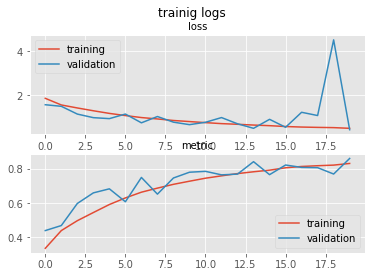

In [50]:
matplotlib.style.use('ggplot')
fig=plt.figure()
plt.subplot(2,1,1)
trainer.training_logs['training loss'].plot(label='training')
trainer.training_logs['validation loss'].plot(label='validation')
plt.legend()
plt.title('loss',fontsize=10)
plt.subplot(2,1,2)
trainer.training_logs['training metric'].plot(label='training')
trainer.training_logs['validation metric'].plot(label='validation')
plt.legend()
plt.title('metric',fontsize=10)
fig.suptitle('trainig logs')

that's all folks!!\
should you want better results,I recommend playing with weight decay, dropout, image size, augmentations or training time.